# Improved simultanious Captioning on ADC->D enviorments of Calvin using CLASP
model and training loop adapted from skillGPT dataset: https://github.com/krishanrana/skillGPT/tree/distributional_SkillGPT

In [6]:
import os
import sys
from datasets.datasetABC import ABCDataset, DDataset
from utils.beamsearch import beamsearch
from utils.util import AttrDict
from utils.visualize import visualize, showImages
from transformers import GPT2Tokenizer
from torch.utils.data import DataLoader, Dataset
from models.generalized_caption_model import ClipGeneralizedCaptionModel, MappingType
from pathlib import Path
import cv2
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from tqdm import tqdm
from enum import Enum
from typing import Optional
from r3m import load_r3m
import clip
from sentence_transformers import SentenceTransformer, util
import torch
import torch.nn as nn
import torch.multiprocessing as mp
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AdamW, get_linear_schedule_with_warmup
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, ToPILImage, InterpolationMode
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.nn import functional as nnf
import wandb
import torch
import itertools
from utils.eval import evaluate_loss_abc_sim, plot_losses
import config as CFG
from utils.generating_captions import generate_annotation_abc
import yaml


'''
    Dataloader
'''
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
datapath_training_parsed = CFG.datapath_training_abcd_parsed
datapath_val_parsed = CFG.datapath_val_abcd_parsed

caption_path_training = f'{CFG.datapath_training_abcd_parsed}/lang_annotations/auto_lang_ann.npy'
caption_path_val = f'{CFG.datapath_val_abcd_parsed}/lang_annotations/auto_lang_ann.npy'

env_info_path = f'{CFG.datapath_training_abcd}/scene_info.npy'
batch_size = 4

train_dataset = ABCDataset(datapath_training_parsed, caption_path_training, env_info_path, tokenizer, CFG.max_seq_length)
val_dataset  = DDataset(datapath_val_parsed, caption_path_val, env_info_path, tokenizer, CFG.max_seq_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=CFG.num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=CFG.num_workers)

test dataloader

In [8]:

for idx, batch in enumerate(train_dataloader):
    print("gpt_tokens: ", batch.gpt_tokens.shape)
    print("gpt_mask: ", batch.gpt_mask.shape)
    print(batch.instruction[0])
    print(list(zip(batch.caption_index[0].tolist(), batch.caption_index[1].tolist()))[0])
    print("actions A: ", batch.actions['A'].shape)
    print("actions B: ", batch.actions['B'].shape)
    print("actions C: ", batch.actions['C'].shape)
    print("state A: ", batch.state['A'].shape)
    print("state B: ", batch.state['B'].shape)
    print("state C: ", batch.state['C'].shape)
    print("observations A: ", batch.observations['A'].shape)
    print("observations B: ", batch.observations['B'].shape)
    print("observations C: ", batch.observations['C'].shape)
    print("batch at index done: ", idx)
    break
print('###################')
for idx, batch in enumerate(val_dataloader):
    print("gpt_tokens: ", batch.gpt_tokens.shape)
    print("gpt_mask: ", batch.gpt_mask.shape)
    print(batch.instruction[0])
    print(list(zip(batch.caption_index[0].tolist(), batch.caption_index[1].tolist()))[0])
    print("actions D: ", batch.actions['D'].shape)
    print("state D: ", batch.state['D'].shape)
    print("observations D: ", batch.observations['D'].shape)
    print("batch at index done: ", idx)
    break


gpt_tokens:  torch.Size([4, 16])
gpt_mask:  torch.Size([4, 16])
push the red block towards the right 

(998651, 998715)
actions A:  torch.Size([4, 64, 7])
actions B:  torch.Size([4, 64, 7])
actions C:  torch.Size([4, 64, 7])
state A:  torch.Size([4, 64, 15])
state B:  torch.Size([4, 64, 15])
state C:  torch.Size([4, 64, 15])
observations A:  torch.Size([4, 64, 2048])
observations B:  torch.Size([4, 64, 2048])
observations C:  torch.Size([4, 64, 2048])
batch at index done:  0
###################
gpt_tokens:  torch.Size([4, 16])
gpt_mask:  torch.Size([4, 16])
open the drawer 

(40, 104)
actions D:  torch.Size([4, 64, 7])
state D:  torch.Size([4, 64, 15])
observations D:  torch.Size([4, 64, 2048])
batch at index done:  0


# Training

define training loop function

In [9]:
clip_model, _ = clip.load("ViT-B/32", device=CFG.device, jit=True)
clip_text_encoder = clip_model.encode_text

def train(model: ClipGeneralizedCaptionModel,
          lr: float = 2e-5, warmup_steps: int = 5000, output_dir: str = ".", output_prefix: str = ""):

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    epochs = CFG.epochs
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    model = model.to(device)
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)

    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=epochs * len(train_dataloader)
    )

    counter = 0
    for epoch in range(epochs):
        print(f">>> Training epoch {epoch}")
        sys.stdout.flush()
        progress = tqdm(total=len(train_dataloader), desc=output_prefix)
        for idx, data in enumerate(train_dataloader):

            model.zero_grad()

            for env in ['A', 'B', 'C']:
                data.observations[env] = data.observations[env].to(CFG.device)
                data.actions[env] = data.actions[env].to(CFG.device)
                #data.state[env] = data.state[env].to(CFG.device)
            data.instruction = clip_text_encoder(clip.tokenize(data.instruction).to(CFG.device)).to(CFG.device)
            data.gpt_tokens = data.gpt_tokens.to(CFG.device)
            data.gpt_mask = data.gpt_mask.to(CFG.device)
            
            outputs = model(data)

            # get logits for envs A,B,C
            losses = []
            logits_shape = data.observations['A'].shape
            for output in outputs:
                logits = output.logits[:, logits_shape[1] - 1: -1]
                loss = nnf.cross_entropy(logits.reshape(-1, logits.shape[-1]), data.gpt_tokens.flatten(), ignore_index=0)
                losses.append(loss)

            average_loss = sum(losses) / len(losses)
            average_loss.backward()
            optimizer.step()
            #loss = nnf.cross_entropy(all_logits.reshape(-1, all_logits.shape[-1]), data.gpt_tokens.flatten(), ignore_index=0)
            #loss.backward()
           
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            progress.set_postfix({"loss": loss.item()})
            wandb.log({"loss": loss.item()})
            progress.update()
            if (idx+1) % 750 == 0:
                torch.save(
                    model.state_dict(),
                    os.path.join(output_dir, f"{output_prefix}-epoch-{epoch:03d}-{counter:03d}.pt"),
                )
                counter += 1
                #val_loss = validate(model)
                #wandb.log({"val_loss": val_loss})
        progress.close()
        if epoch % 1 == 0 or epoch == epochs - 1:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-epoch-{epoch:03d}-{counter:03d}.pt"),
            )
            counter += 1
    return model

start train

In [10]:
wandb.init(project="clipcalvinABC")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

prefix_length = 10
prefix_length_clip = 10
num_layers = 8
prefix_dim = 512
mapping_type = {'mlp': MappingType.MLP, 'transformer': MappingType.Transformer}["transformer"]

model = ClipGeneralizedCaptionModel(prefix_length, clip_length=prefix_length_clip, prefix_size=prefix_dim,
                          num_layers=num_layers, mapping_type=mapping_type)


clip_model, _ = clip.load("ViT-B/32", device=CFG.device, jit=True)
clip_text_encoder = clip_model.encode_text

output_dir = "/media/tim/D/checkpoints_calvin/calvcap_abcd/run_5"
train(model, output_dir=output_dir, output_prefix="calvcap_abc_prefix")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: timlauffs. Use `wandb login --relogin` to force relogin


>>> Training epoch 0


/home/tim/anaconda3/envs/myenv/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
calvcap_abc_prefix:   0%|          | 2/4468 [00:03<1:44:44,  1.41s/it, loss=7.83]

KeyboardInterrupt: 

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9e80786850>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f9e8078c610, execution_count=10 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 7f9e34a98e50, raw_cell="wandb.init(project="clipcalvinABC")
os.environ['TF.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/media/tim/E/hulc_captioning/captioning/captioning_ABC_D.ipynb#X26sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

## Evaluate
find best model

In [3]:

# Training checkpoint model directory
model_dir = "/media/tim/D/checkpoints_calvin/hulccap_abcd/run_3_improved_full"
# csv file path to save losses (make sure this exists before executing code)
csv_filepath = "./results/abc_d/csv/abcd_loss_improved_full.csv"


clip_model, _ = clip.load("ViT-B/32", device=CFG.device, jit=True)
clip_text_encoder = clip_model.encode_text

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 


best_model = None
best_loss = float('inf')
results = []

for filename in os.listdir(model_dir):
    epoch = filename[-6:-3]
    try:
        epoch_ = int(epoch)
        print(epoch)
        model_path = os.path.join(model_dir, filename)
        val_loss = evaluate_loss_abc_sim(model_path, val_dataloader, envs=['D'],  mode='val')
        train_loss = evaluate_loss_abc_sim(model_path, train_dataloader, envs=['A','B','C'],  mode='train')
        print(filename, ' val_loss: ', val_loss, ' train_loss: ', train_loss)
        results.append({'epoch': epoch, 'filename': filename,  'val_loss': val_loss, 'train_loss': train_loss})
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = filename
    except:
        print("error getting epoch number")

print("best model: ", best_model, ' loss: ', best_loss)
results.sort(key=lambda x: x['epoch'])

with open(csv_filepath, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=['epoch', 'filename', 'val_loss', 'train_loss'])
    writer.writeheader()
    for result in results:
        writer.writerow(result)
    
print("wrote results to ", csv_filepath)

007
hulccap_abc_prefix-epoch-001-007.pt  val_loss:  0.5941593330353498  train_loss:  0.39844166422421207
053
error getting epoch number
014


plot losses

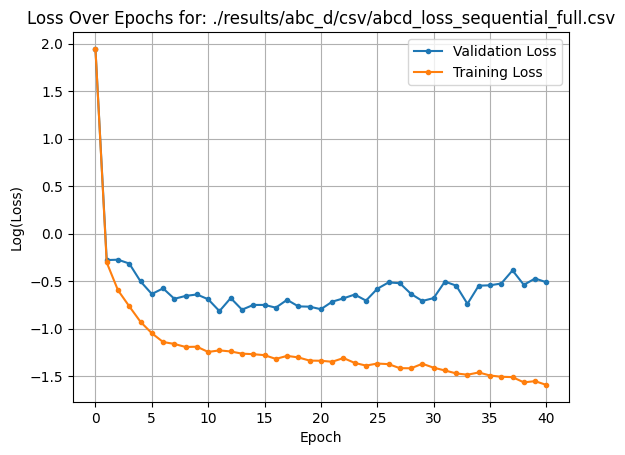

best loss for  ./results/abc_d/csv/abcd_loss_sequential_full.csv  for epoch  11 :  0.4419470724168715


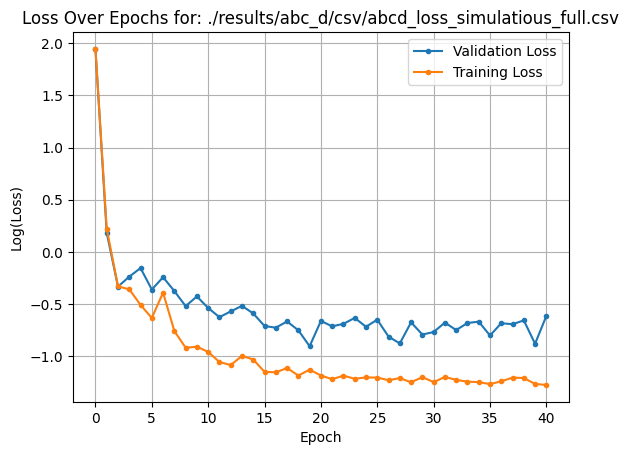

best loss for  ./results/abc_d/csv/abcd_loss_simulatious_full.csv  for epoch  19 :  0.4044126502840834


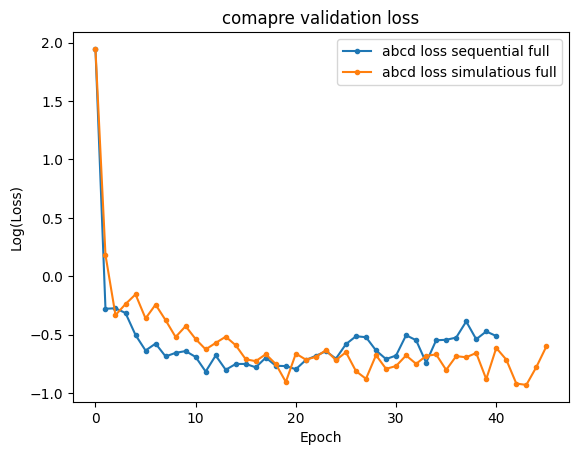

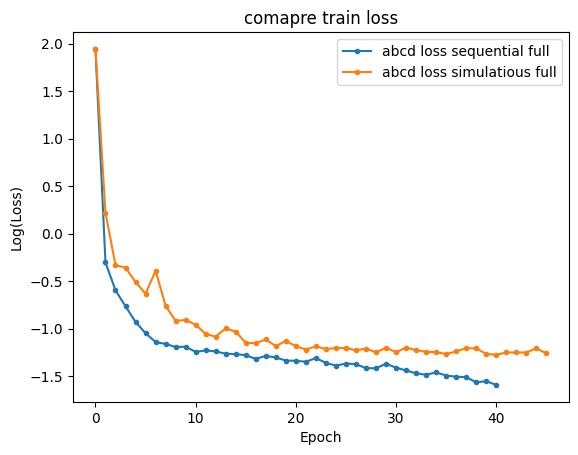

In [4]:
csv_folder = "./results/abc_d/csv"
plot_losses(csv_folder)

Test caption generation beam decooding

INSTRUCTION GROUND: open the drawer 
  at index:  [tensor([40]), tensor([104])]
[('grasp the handle of the drawer, then open it', tensor(0.8453, device='cuda:0')), ('grasp the drawer handle, then open it', tensor(0.8339, device='cuda:0')), ('grasp the handle of the drawer and open it', tensor(0.8186, device='cuda:0')), ('grasp the drawer handle and open it', tensor(0.7998, device='cuda:0')), ('go open the drawer', tensor(0.7304, device='cuda:0'))]


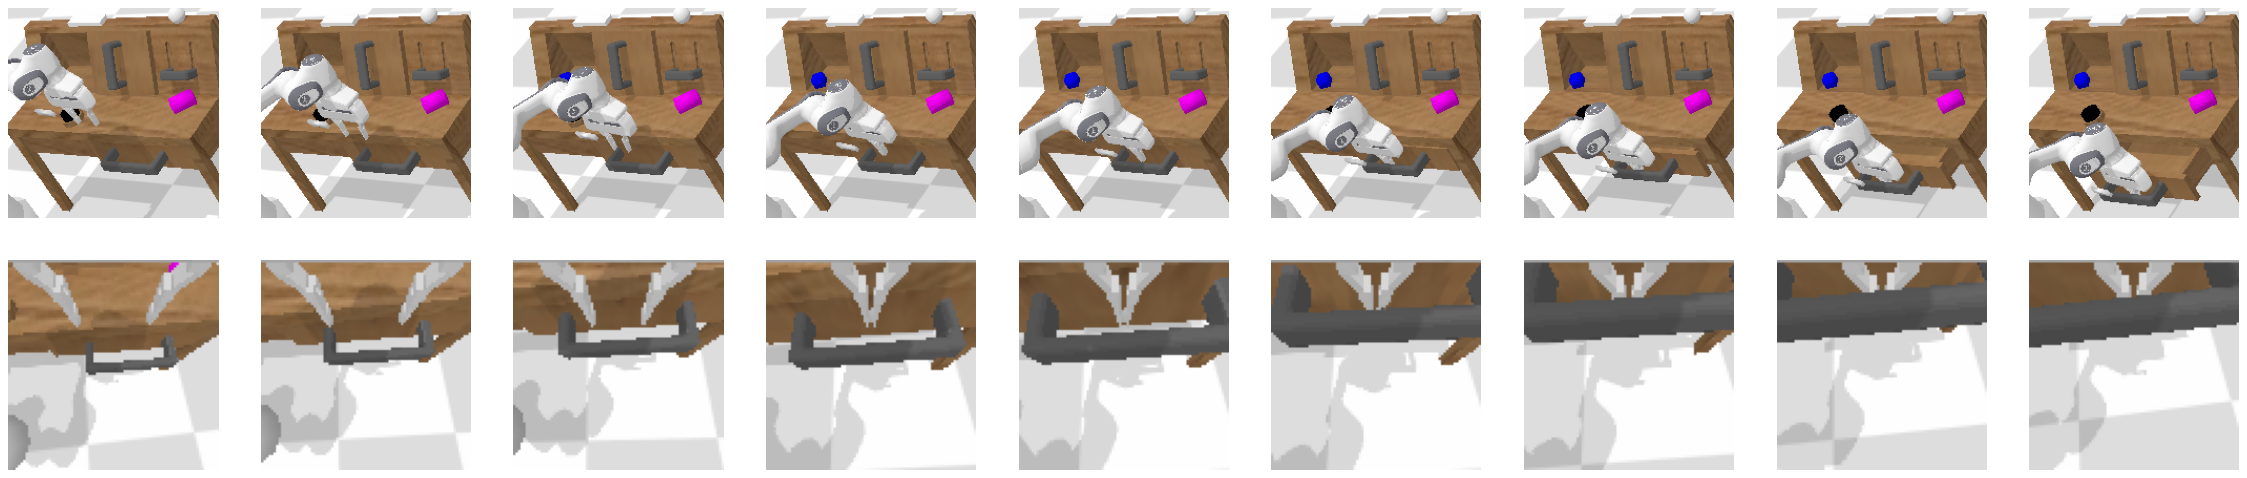

INSTRUCTION GROUND: grasp the handle of the drawer, then open it 
  at index:  [tensor([48]), tensor([112])]
[('grasp the handle of the drawer, then open it', tensor(0.8459, device='cuda:0')), ('grasp the drawer handle, then open it', tensor(0.8356, device='cuda:0')), ('grasp the handle of the drawer and open it', tensor(0.8180, device='cuda:0')), ('grasp the drawer handle and open it', tensor(0.7998, device='cuda:0')), ('go open the drawer', tensor(0.7279, device='cuda:0'))]


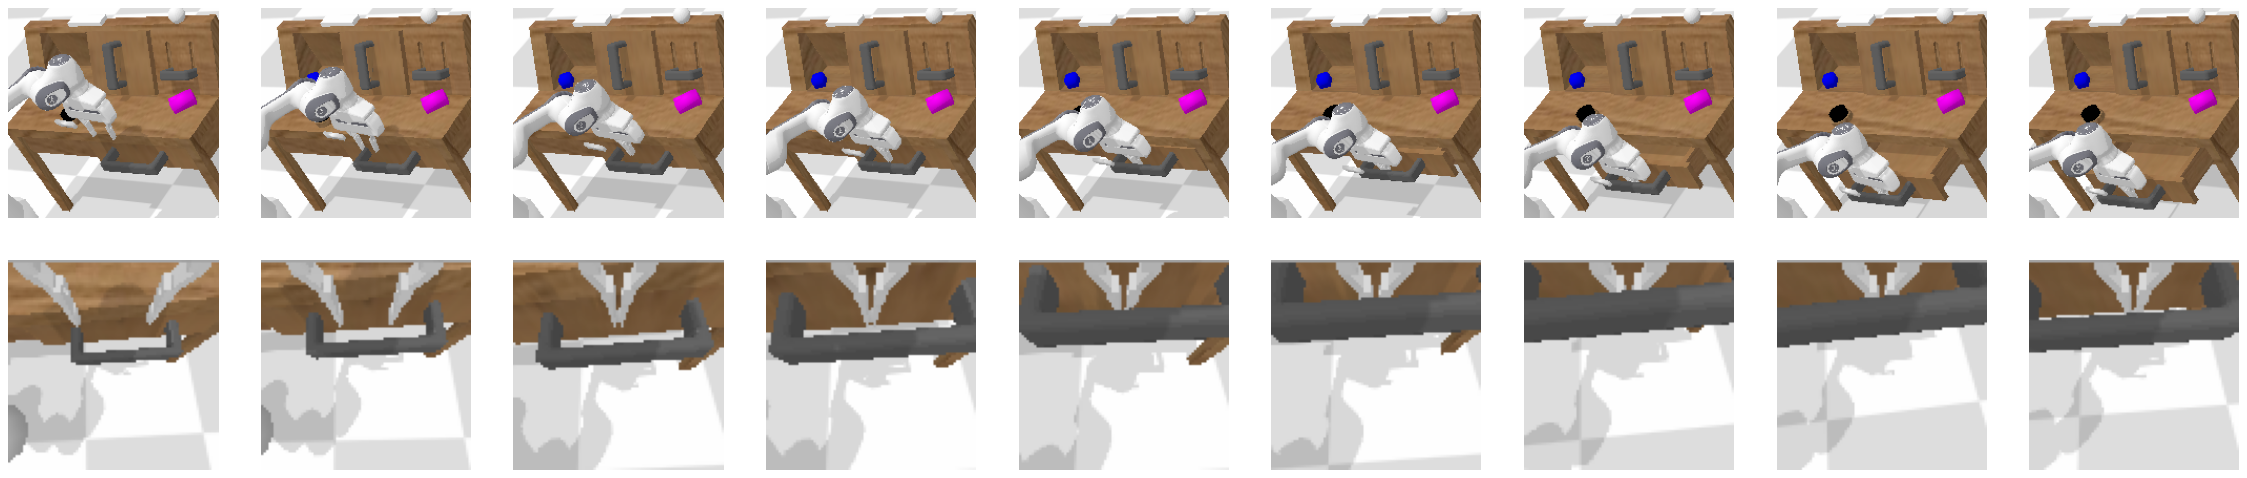

INSTRUCTION GROUND: toggle the button to turn on the led light 
  at index:  [tensor([152]), tensor([216])]
[('push the button to turn on the green light', tensor(0.8209, device='cuda:0')), ('push down the button to turn on the led light', tensor(0.8060, device='cuda:0')), ('push the button to turn on the led light', tensor(0.8011, device='cuda:0')), ('push the button to turn on the led', tensor(0.7898, device='cuda:0')), ('push down the button to turn on the led', tensor(0.7768, device='cuda:0'))]


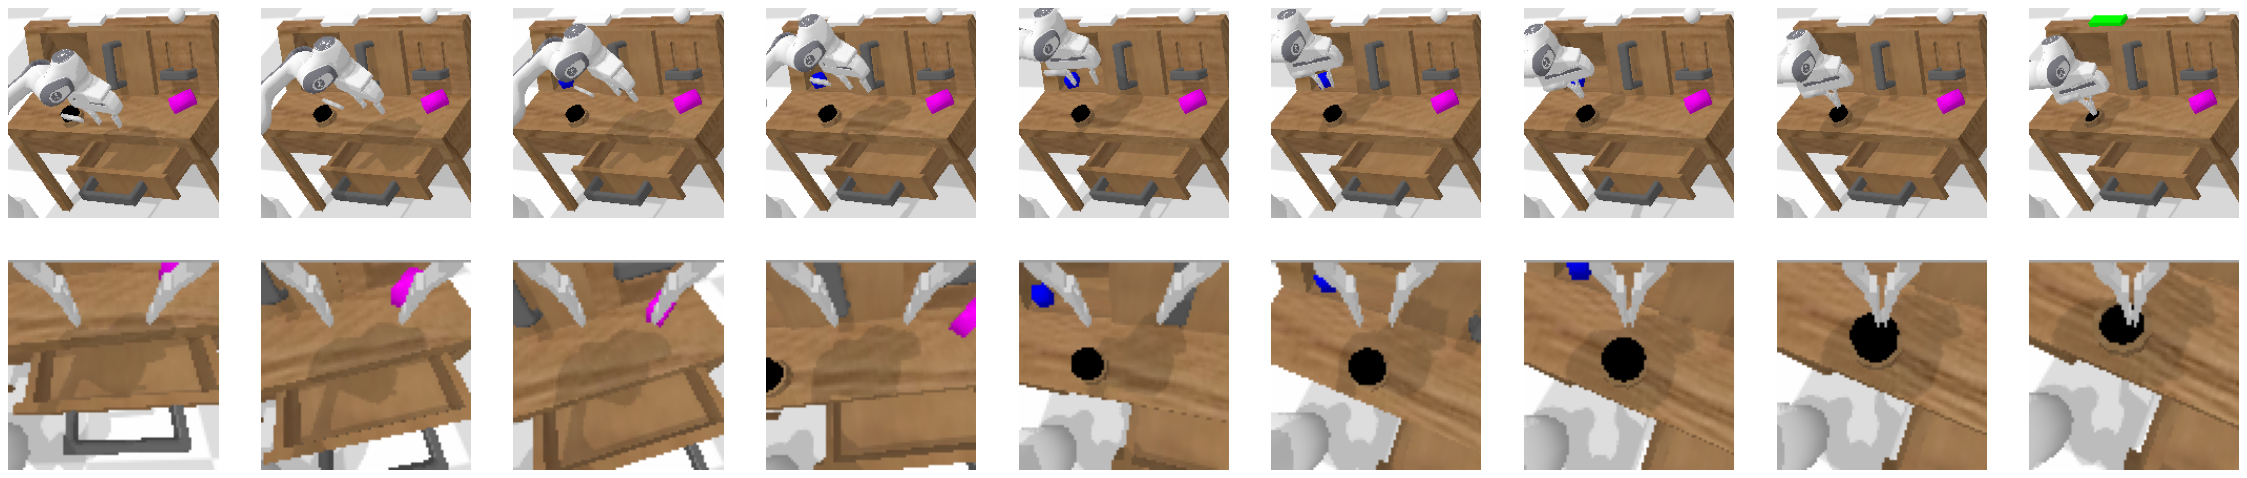

INSTRUCTION GROUND: push down the button to turn on the led light 
  at index:  [tensor([160]), tensor([224])]
[('push the blue block to the left', tensor(0.8222, device='cuda:0')), ('push the blue block towards the left', tensor(0.8133, device='cuda:0')), ('slide the blue block towards the left', tensor(0.7724, device='cuda:0')), ('slide left the blue block', tensor(0.7369, device='cuda:0')), ('push left the blue block', tensor(0.7124, device='cuda:0'))]


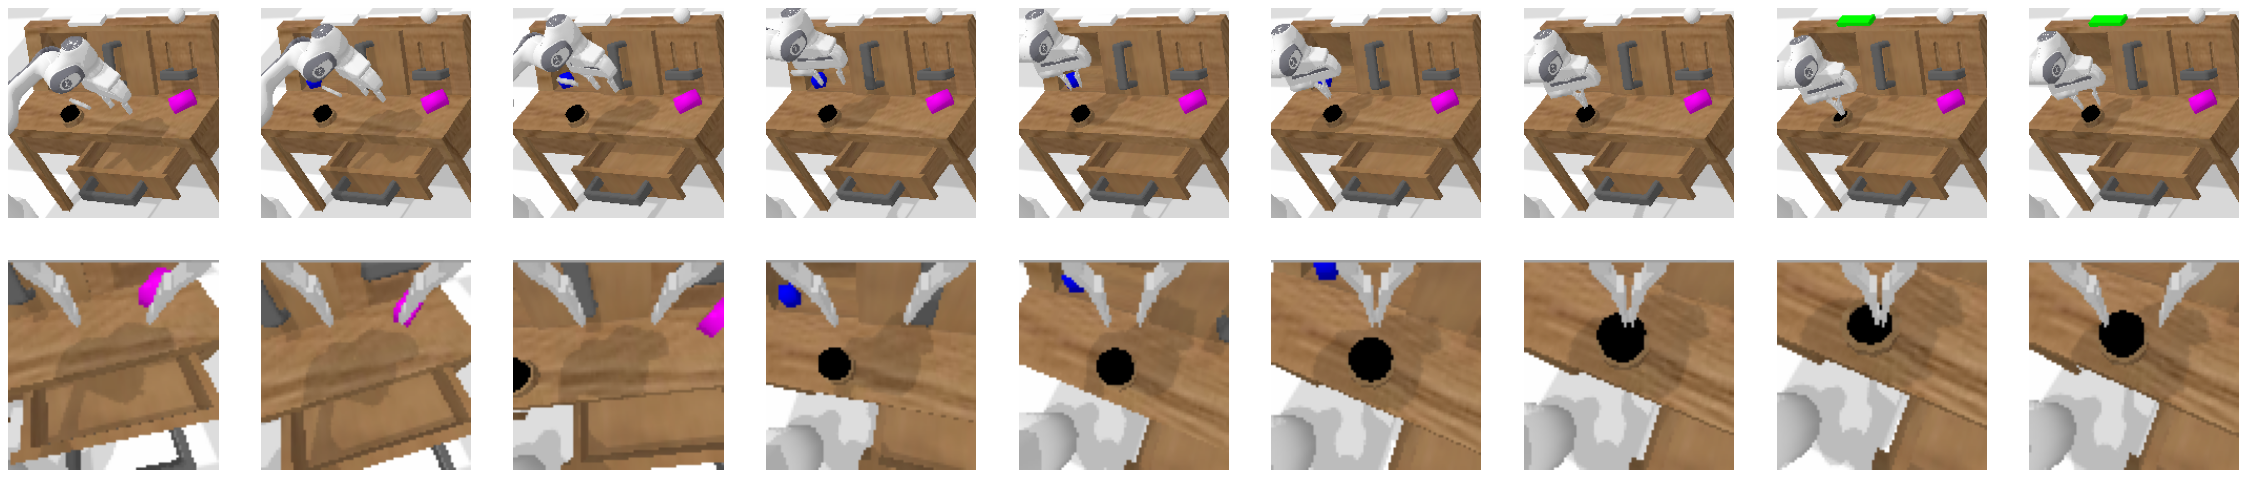

INSTRUCTION GROUND: lift the blue block lying in the sliding cabinet 
  at index:  [tensor([264]), tensor([328])]
[('pick up the blue block in the sliding cabinet', tensor(0.8131, device='cuda:0')), ('lift the blue block lying in the slider', tensor(0.7979, device='cuda:0')), ('pick up the blue block from the sliding cabinet', tensor(0.7956, device='cuda:0')), ('grasp the blue block lying in the slider', tensor(0.7698, device='cuda:0')), ('lift the blue block on the shelf', tensor(0.7579, device='cuda:0'))]


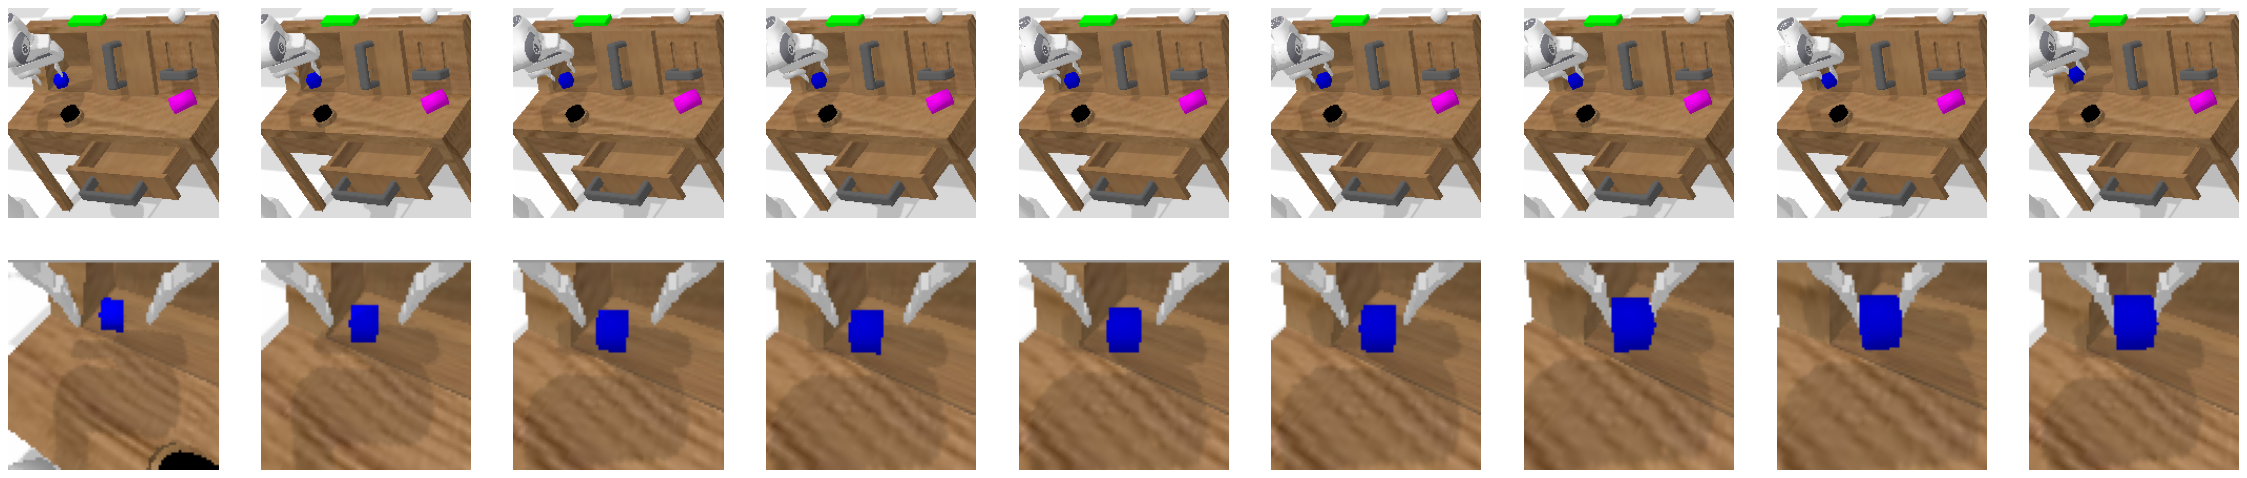

INSTRUCTION GROUND: in the sliding cabinet grasp the blue block 
  at index:  [tensor([272]), tensor([336])]
[('pick up the blue block in the sliding cabinet', tensor(0.8120, device='cuda:0')), ('lift the blue block lying in the slider', tensor(0.7972, device='cuda:0')), ('lift the blue block lying in the cabinet', tensor(0.7772, device='cuda:0')), ('grasp the blue block lying in the slider', tensor(0.7694, device='cuda:0')), ('lift the blue block on the shelf', tensor(0.7581, device='cuda:0'))]


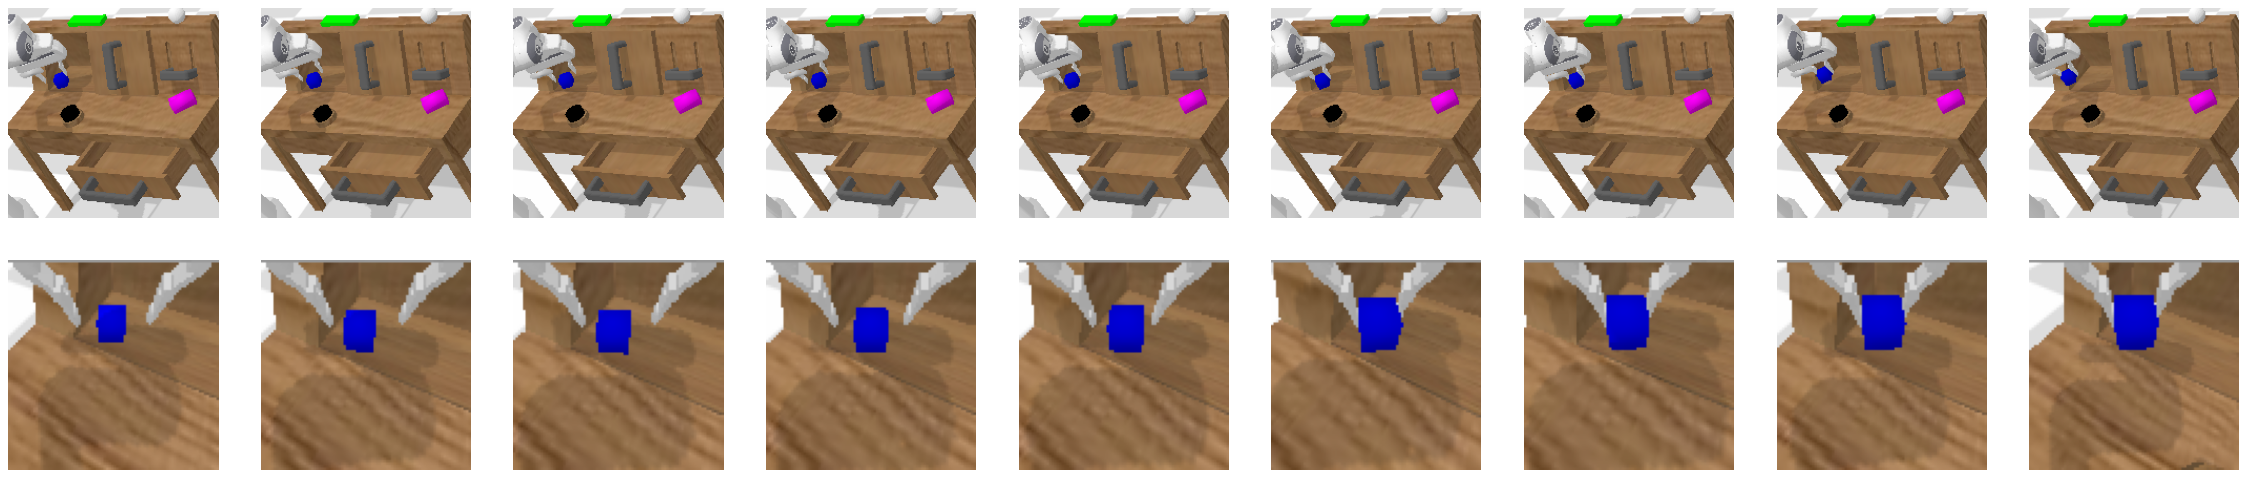

INSTRUCTION GROUND: grasp the door handle and slide the door to the left 
  at index:  [tensor([376]), tensor([440])]
[('grasp the door handle, then move the door to the left', tensor(0.8119, device='cuda:0')), ('grasp the door handle, then slide the door to the left', tensor(0.8088, device='cuda:0')), ('grasp the door handle and move the door to the left', tensor(0.7981, device='cuda:0')), ('push the sliding door to the left', tensor(0.7601, device='cuda:0')), ('push the door to the left side', tensor(0.7449, device='cuda:0'))]


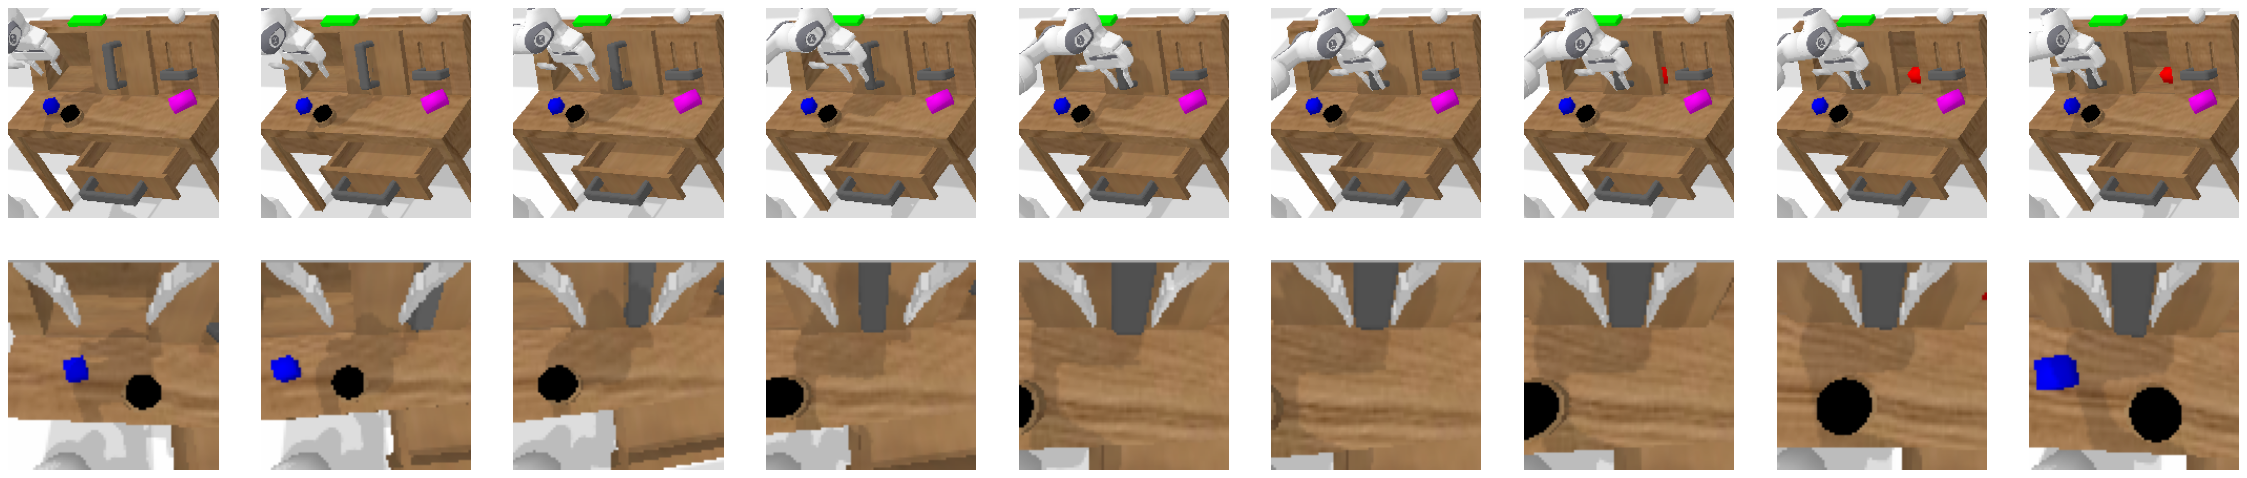

INSTRUCTION GROUND: move the door all the way to the left 
  at index:  [tensor([384]), tensor([448])]
[('slide the blue block towards the left', tensor(0.7785, device='cuda:0')), ('grasp the blue block, then rotate it right', tensor(0.7727, device='cuda:0')), ('push the blue block to the left', tensor(0.7711, device='cuda:0')), ('push the blue block towards the left', tensor(0.7693, device='cuda:0')), ('grasp the blue block and rotate it right', tensor(0.7460, device='cuda:0'))]


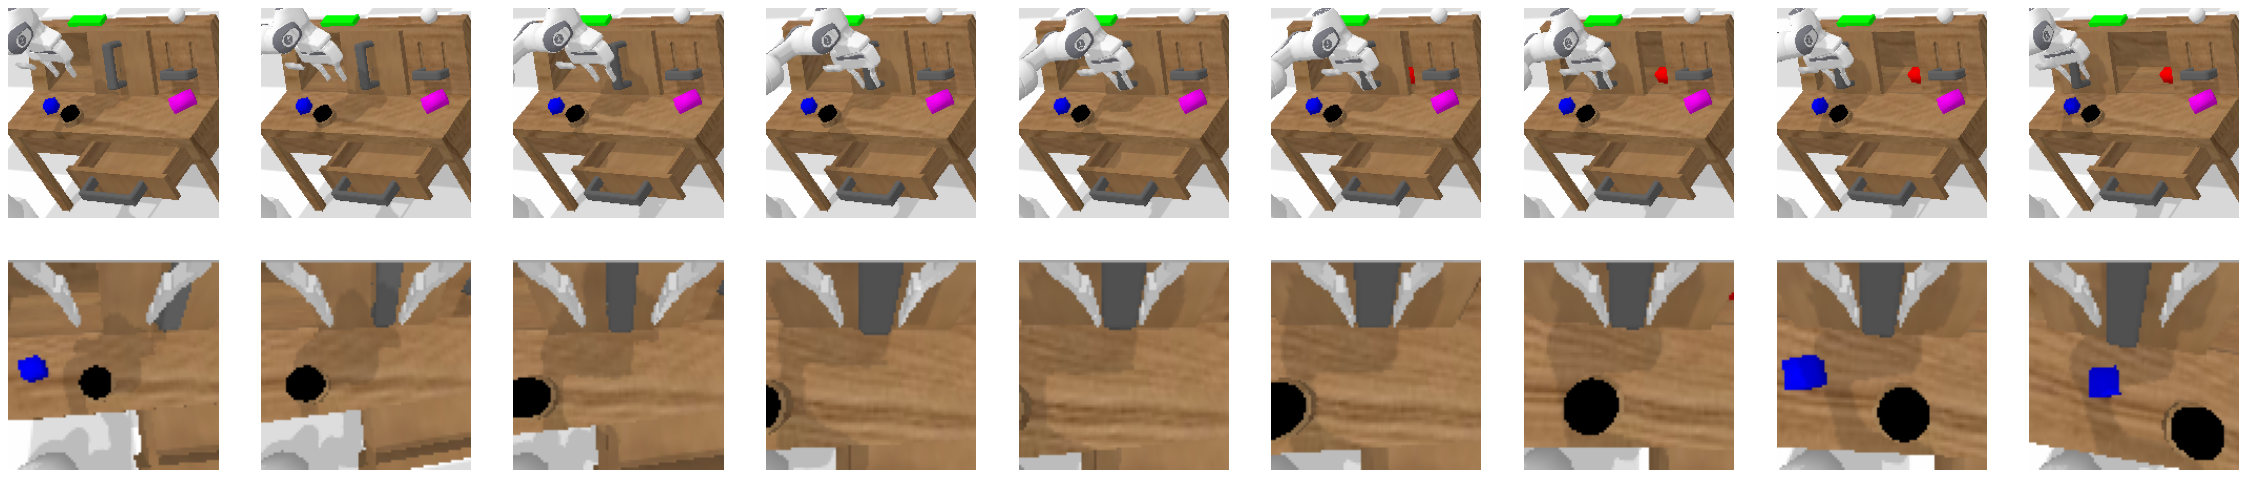

INSTRUCTION GROUND: pick up the red block from the sliding cabinet 
  at index:  [tensor([480]), tensor([544])]
[('pick up the pink block in the sliding cabinet', tensor(0.7973, device='cuda:0')), ('lift the pink block lying in the slider', tensor(0.7823, device='cuda:0')), ('lift the pink block lying in the cabinet', tensor(0.7727, device='cuda:0')), ('pick up the pink block from the shelf', tensor(0.7709, device='cuda:0')), ('grasp the pink block lying in the slider', tensor(0.7573, device='cuda:0'))]


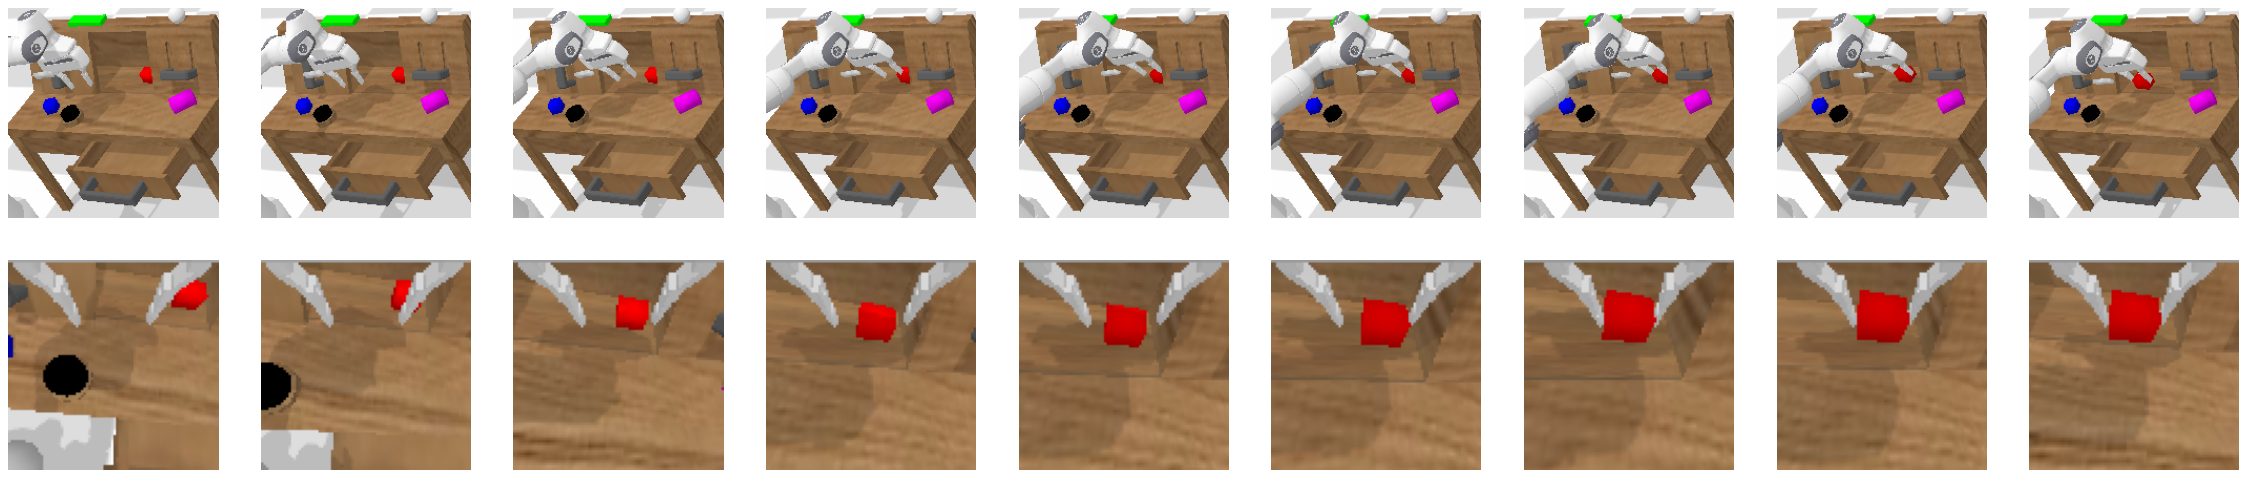

INSTRUCTION GROUND: store the object in the drawer 
  at index:  [tensor([536]), tensor([600])]
[('move to the drawer, then store the object', tensor(0.8331, device='cuda:0')), ('move to the drawer, then place the object', tensor(0.8306, device='cuda:0')), ('move to the drawer and store the object', tensor(0.8266, device='cuda:0')), ('move to the drawer and place the object', tensor(0.8223, device='cuda:0')), ('put the object in the drawer', tensor(0.7467, device='cuda:0'))]


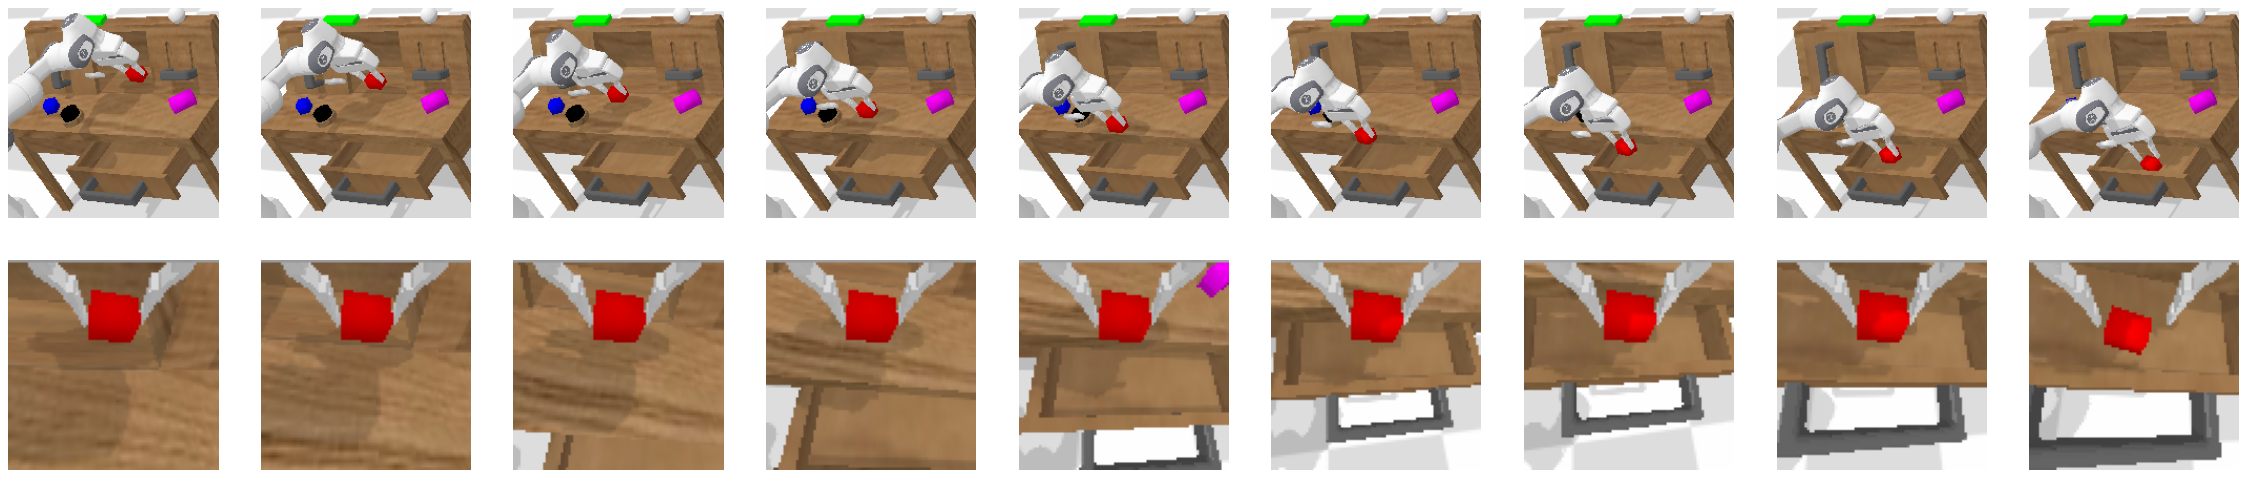

In [5]:
path_best = "./checkpoints/calvcap_abcd/simultaneous_abcd/hulccap_abc_prefix-best.pt"
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=CFG.num_workers)


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

clip_model, _ = clip.load("ViT-B/32", device=CFG.device, jit=True)
clip_text_encoder = clip_model.encode_text

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

best_model = ClipGeneralizedCaptionModel(prefix_length=10, clip_length=10).to(CFG.device)
best_model.load_state_dict(torch.load(path_best, map_location=CFG.device))
best_model = best_model.eval()

for data in itertools.islice(val_dataloader, 0, 10):

    instruction_ground = data.instruction
    index_ground = data.caption_index
    data.observations['D'] = data.observations['D'].to(CFG.device)
    data.actions['D'] = data.actions['D'].to(CFG.device)
    #data.state = data.state.to(CFG.device)
    data.gpt_tokens = data.gpt_tokens.to(CFG.device)
    data.gpt_mask = data.gpt_mask.to(CFG.device)

    for i in range(len(data.instruction)):
        print("INSTRUCTION GROUND:", instruction_ground[i], " at index: ", index_ground)  
        # print(data.observations.shape)
        # src = AttrDict(observations=data.observations, actions=data.actions, state=data.state)
        src = AttrDict(observations=data.observations['D'], actions=data.actions['D'])
        behaviour_encoding = best_model.behaviour_encoder(src)
        prefix_embed = best_model.project_to_gpt(behaviour_encoding)
        generated_caption =  beamsearch(best_model, tokenizer, prefix_embed)
        print(generated_caption)
        showImages(index_ground[0].item(), CFG.datapath_val)

Other evaulations (calulaing accuracy, generaed captions using sliding window... ) can be deone using the checkpoint in the captioning.ipynb notebook